# <center>**Resolución Trabajo Práctico Número 2**</center>

#### <center>Visión por computadoras I - CEIA, Fiuba</center>

---

**Alumnas:**

- Espínola, Carla
- Gambarte, Antonella Nerea

---


In [80]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

### 1. Obtener una detección del logo en cada imagen sin falsos positivos


In [81]:
template = cv2.imread('./template/pattern.png', 0)
w, h = template.shape[::-1]

image_paths = glob.glob('./images/*.png')

In [82]:
def detectar_logo_multiescala(imagen_path, template, threshold=0.8, escalas=np.linspace(0.5, 1.5, 10)):
    img_rgb = cv2.imread(imagen_path)
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    mejor_conf = -1
    mejor_top_left = None
    mejor_w, mejor_h = 0, 0
    for escala in escalas:
        temp_resized = cv2.resize(template, (int(template.shape[1]*escala), int(template.shape[0]*escala)))
        if temp_resized.shape[0] > img_gray.shape[0] or temp_resized.shape[1] > img_gray.shape[1]:
            continue
        #res = cv2.matchTemplate(img_gray, temp_resized, cv2.TM_CCOEFF_NORMED)
        res = cv2.matchTemplate(img_gray, temp_resized, cv2.TM_CCORR_NORMED)
        #res = cv2.matchTemplate(img_gray, temp_resized, cv2.TM_SQDIFF_NORMED)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
        if max_val > mejor_conf:
            mejor_conf = max_val
            mejor_top_left = max_loc
            mejor_w, mejor_h = temp_resized.shape[1], temp_resized.shape[0]
    if mejor_conf >= threshold:
        bottom_right = (mejor_top_left[0] + mejor_w, mejor_top_left[1] + mejor_h)
        cv2.rectangle(img_rgb, mejor_top_left, bottom_right, (0,255,0), 2)
        plt.imshow(cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB))
        plt.title(f'Confianza: {mejor_conf:.2f}')
        plt.axis('off')
        plt.show()
    else:
        print(f"No se detectó logo en {imagen_path}")

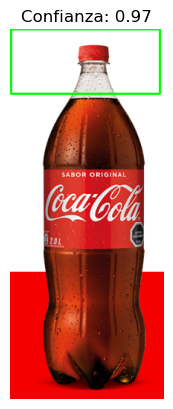

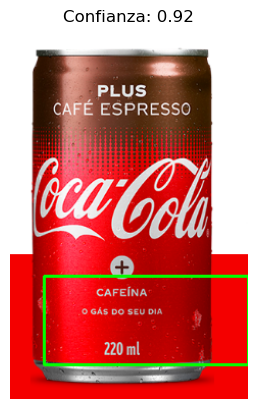

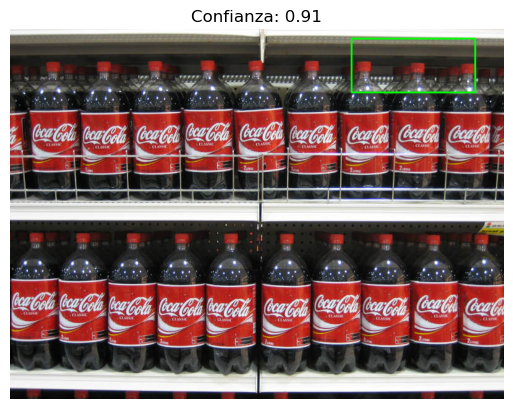

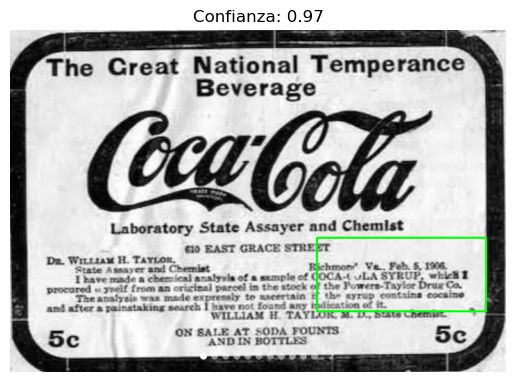

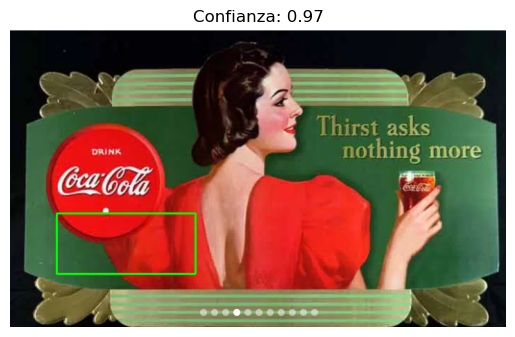

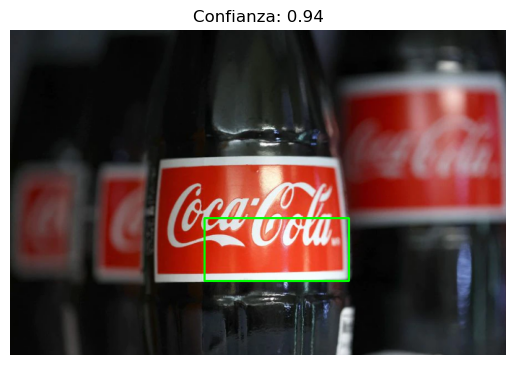

In [83]:
for img_path in image_paths:
    detectar_logo_multiescala(img_path, template, threshold=0.1)

### 2. Plantear y validar un algoritmo para múltiples detecciones en la imagen coca_multi.png con el mismo témplate del ítem 1


Para la detección multiple del logo se aplicó Template Matching, utilizando Laplaciano y mejoras adicionales como CLAHE , Gaussian Blur y Non-Maximum Suppression (NMS).

- Mejora del contraste (CLAHE): se aplica la técnica CLAHE tanto a la imagen como a la plantilla para mejorar el contraste. Esto ayuda a mejorar la visibilidad de los detalles y características del logo en la imagen.

- Preprocesamiento Blur y Laplaciano: se aplica un Gaussian Blur para suavizar las imágenes y reducir el ruido, lo que ayuda a que el filtro Laplaciano se enfoque en las características de la imagen sin ser afectado por detalles irrelevantes. El filtro Laplaciano resalta las áreas de alto contraste, que son las que probablemente contengan las características más importantes del logo.

- Umbralización : se aplica un umbral binario para eliminar los valores de píxeles bajos que no aportan información significativa.

- Template Matching: la plantilla se escala en varios tamaños para detectar el logo a diferentes escalas en la imagen.

- Non-Maximum Suppression (NMS): se aplica para eliminar las detecciones redundantes y solapadas. Solo se mantiene la detección con la puntuación más alta para cada área.

- Filtrado por Harris: se aplica para verificar que las regiones detectadas contengan suficientes esquinas fuertes, lo que indica que son características clave de la imagen y no simplemente ruido.


In [84]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def detect_multi_logo(path, min_scale=0.2, amount_scales=10, method=cv.TM_CCORR_NORMED, threshold=0.96, 
 nms_overlap_thresh=0.3, harris_min_corners_ratio=0.15, min_score=0.9):
   
    # --- Carga de imagen y template ---
    img = cv.imread(path)
    tpl = cv.imread('template/pattern.png', 0)

    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # --- CLAHE para mejorar contraste ---
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_eq = clahe.apply(img_gray)
    tpl_eq = clahe.apply(tpl)

    # --- Blur para suavizar imágenes y Laplaciano ---
    img_blur = cv.GaussianBlur(img_eq, (3,3), 0)
    tpl_blur = cv.GaussianBlur(tpl_eq, (3,3), 0)

    lap_img = cv.Laplacian(img_blur, cv.CV_64F, ksize=3)
    lap_img = cv.convertScaleAbs(lap_img)

    lap_tpl = cv.Laplacian(tpl_blur, cv.CV_64F, ksize=3)
    lap_tpl = cv.convertScaleAbs(lap_tpl)

    # --- Umbralización para eliminar ruido ---
    _, lap_img = cv.threshold(lap_img, 10, 255, cv.THRESH_BINARY)
    _, lap_tpl = cv.threshold(lap_tpl, 10, 255, cv.THRESH_BINARY)

    img_h, img_w = lap_img.shape
    t_h, t_w = lap_tpl.shape

    # Escalas
    max_scale = max(min(img_w / t_w, img_h / t_h), min_scale)
    scales = np.linspace(min_scale, max_scale, amount_scales)

    # --- Template Matching ---
    all_boxes = []
    for scale in scales:
        w_s = int(t_w * scale)
        h_s = int(t_h * scale)
        if w_s < 10 or h_s < 10 or w_s > img_w or h_s > img_h:
            continue

        tpl_resized = cv.resize(lap_tpl, (w_s, h_s), interpolation=cv.INTER_AREA)
        res = cv.matchTemplate(lap_img, tpl_resized, method)

        res_score = cv.normalize(res, None, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)

        # Localizamos picos por threshold
        loc = np.where(res_score >= threshold)
        for pt in zip(*loc[::-1]): 
            x, y = pt
            score = float(res_score[y, x])

            # Filtramos detecciones con puntuaciones bajas antes de NMS
            if score < min_score:
                continue

            all_boxes.append([x, y, x + w_s, y + h_s, score])

    # --- NMS --- 
    nms_boxes = []
    scores = []
    for box in all_boxes:
        x1, y1, x2, y2, score = box
        w = x2 - x1
        h = y2 - y1
        nms_boxes.append([x1, y1, w, h])
        scores.append(score)

    nms_boxes = np.array(nms_boxes)
    scores = np.array(scores)

    nms_indices = cv.dnn.NMSBoxes(nms_boxes.tolist(), scores.tolist(), score_threshold=min_score, nms_threshold=nms_overlap_thresh)

    # Filtramos las cajas finales después de NMS
    final_boxes_with_harris = []
    if len(nms_indices) > 0:
        for i in nms_indices.flatten():
            final_boxes_with_harris.append(all_boxes[i])

    # --- Verificación Harris ---
    final_boxes_filtered = []
    for b in final_boxes_with_harris:
        if len(b) == 5:
            x1, y1, x2, y2, sc = b
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(img_w, x2), min(img_h, y2)
            
            region = img_eq[y1:y2, x1:x2]
            
            if region.size == 0:
                continue

            # Harris
            dst = cv.cornerHarris(np.float32(region), 2, 3, 0.04)

            # Contar las esquinas significativas
            strong_corners = np.sum(dst > 0.01 * dst.max())

            # Filtramos las detecciones que no tienen suficientes esquinas
            min_corners = max(3, int(harris_min_corners_ratio * region.size))
            
            if strong_corners >= min_corners:
                final_boxes_filtered.append((x1, y1, x2, y2, sc))

    # --- Gráfico ---
    img_out = img_rgb.copy()
    for (x1, y1, x2, y2, val) in final_boxes_filtered:
        cv.rectangle(img_out, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv.putText(img_out, f"{val:.2f}", (x1, max(5, y1 - 5)), cv.FONT_HERSHEY_SIMPLEX, 0.45, (255, 255, 0), 1)

    # Mostrar resultados
    plt.figure(figsize=(8, 8))
    plt.imshow(img_out)
    plt.title(f'Threshold={threshold}')
    plt.axis('off')
    plt.show()

    return img_out, final_boxes_filtered


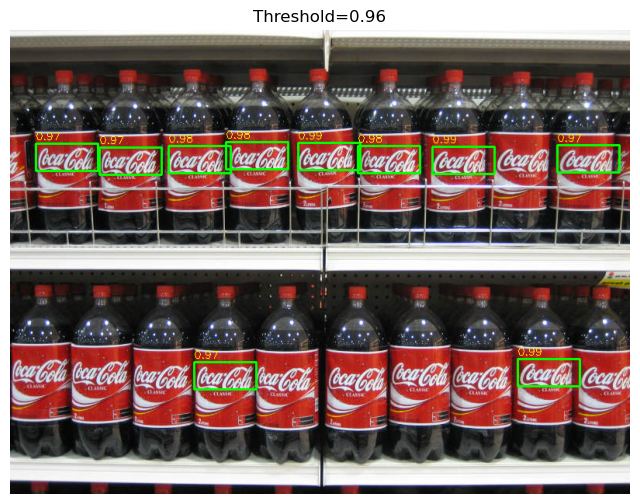

In [85]:
out_img, boxes = detect_multi_logo('images/coca_multi.png')

### 3. Generalizar el algoritmo del item 2 para todas las imágenes.


In [86]:
for img_path in image_paths:
    print(f'Detectando en: {img_path}')
    # detectar_multiples(img_path, template)

Detectando en: ./images\coca_logo_1.png
Detectando en: ./images\coca_logo_2.png
Detectando en: ./images\coca_multi.png
Detectando en: ./images\coca_retro_1.png
Detectando en: ./images\coca_retro_2.png
Detectando en: ./images\logo_1.png
